In [1]:
import torch
import torchvision
import sklearn.metrics as metrics
import numpy as np
import sys
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import datetime
from helper import get_cat_count, count_parameters, compute_confusion_matrix, show_examples, plot_training_loss, plot_accuracy, plot_confusion_matrix

# COMP9444 Assignment 2

## Cat breed classification

## Neural Network

**student.py**

UNSW COMP9444 Neural Networks and Deep Learning

You may modify this file however you wish, including creating additional
variables, functions, classes, etc., so long as your code runs with the
hw2main.py file unmodified, and you are only using the approved packages.

You have been given some default values for the variables train_val_split,
batch_size as well as the transform function.
You are encouraged to modify these to improve the performance of your model.

**Answer to Question:**

Briefly describe how your program works, and explain any design and training
decisions you made along the way.

In [14]:
############################################################################
######     Specify transform(s) to be applied to the input images     ######
############################################################################

# def transform(mode):
#     """
#     Called when loading the data. Visit this URL for more information:
#     https://pytorch.org/vision/stable/transforms.html
#     You may specify different transforms for training and testing
#     """

#     # channel size = 3

#     if mode == 'train':
#         return transforms.Compose(
#             [  
#                 transforms.Resize((256, 256)),
#                 transforms.RandomCrop((224, 224)), # common crop size for imagenet data, for using our ResNet
#                 transforms.ColorJitter(brightness=0.5),
#                 transforms.RandomRotation(degrees=30),
#                 transforms.RandomHorizontalFlip(p=0.5),
#                 transforms.RandomGrayscale(p=0.3),
#                 transforms.RandomAutocontrast(),
#                 transforms.ToTensor()
#             ]
#         )
#     elif mode == 'test':
#         return transforms.Compose(
#             [   
#                 transforms.Resize((224, 224)),
#                 transforms.ToTensor()
#             ]
#         )



############################################################################
######     Specify transform(s) to be applied to the input images     ######
############################################################################

def transform(mode):
    """
    Called when loading the data. Visit this URL for more information:
    https://pytorch.org/vision/stable/transforms.html
    You may specify different transforms for training and testing
    """

    # channel size = 3

    if mode == 'train':
        return transforms.Compose(
            [   
                transforms.RandomResizedCrop(size=80, 
                         scale=(0.75, 1.0), ratio=(0.75, 1.3)), # original 80*80, avoid cropping important info
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation((-20, 20)),
                transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.3, hue=0.2),
                transforms.RandomPosterize(bits=3, p=0.4),
                transforms.RandomEqualize(p=0.2),
                transforms.RandomGrayscale(p=0.3),
                transforms.RandomPerspective(distortion_scale=0.05, p=0.2, fill=0),
                transforms.ToTensor()
            ]
        )
    elif mode == 'test':
        return transforms.Compose(
            [   
                transforms.ToTensor()
            ]
        )

### ResNet with convolutional block

> Resizing logic (note this does skip connections after 2 conv layers because figure is ResNet-50, however for ResNet-34 and ResNet-18 we skip after 1 conv block  

![conv block resnet](./ResidualBlock.png)

image source: https://stackoverflow.com/questions/58200107/stuck-understanding-resnets-identity-block-and-convolutional-blocks

Helpful resources (implementations of residual blocks): https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L14/2-resnet-example.ipynb 

https://stackoverflow.com/questions/60817390/implementing-a-simple-resnet-block-with-pytorch


In [15]:
#################################################################################
#####                      Specify NN to be used                           ######
#################################################################################

# Trying an implementation of ResNet 

class IdentityResidualBlock(nn.Module):
    def __init__(self, input_channel, output_channel):
        super().__init__()
        
        if input_channel != output_channel:
            raise ValueError(f'Use ConvolutionalResidualBlock. input_channel={input_channel} != output_channel={output_channel}')
        
        self.block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            
            nn.Conv2d(output_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel)
        )
        
        
    def forward(self, x):
        shortcut = x
        block = self.block(x)
        x = F.relu(block + shortcut)
        return x


class ConvolutionalResidualBlock(nn.Module):
    def __init__(self, input_channel, output_channel):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            
            nn.Conv2d(output_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel)
        )
        
        # Adjusting channels of input layers to make addition to output layer possible.
        self.skip_connection = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(output_channel)
        )
        
        
    def forward(self, x):
        shortcut = self.skip_connection(x)
        block = self.block(x)
        x = F.max_pool2d(F.relu(block + shortcut), 2)
        return x


## Should we try maxpooling after residual blocks?
## ResNet18 Architecture: https://www.researchgate.net/figure/Original-ResNet-18-Architecture_fig1_336642248
## ResNet18 Architecture: https://www.researchgate.net/profile/Paolo-Napoletano/publication/322476121/figure/tbl1/AS:668726449946625@1536448218498/ResNet-18-Architecture.png
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.initial_cnn_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 2)),
        )
        
        self.residual_block_1 = IdentityResidualBlock(64, 64)
        self.residual_block_2 = ConvolutionalResidualBlock(64, 128)
        
        self.residual_block_3 = IdentityResidualBlock(128, 128)
        self.residual_block_4 = ConvolutionalResidualBlock(128, 256)
        
        self.residual_block_5 = IdentityResidualBlock(256, 256)
        self.residual_block_6 = ConvolutionalResidualBlock(256, 512)
        
        self.residual_block_7 = IdentityResidualBlock(512, 512)
        
        # shrink final conv layer width to 1
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512*1*1, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            
            nn.Dropout(p=0.2),
            nn.Linear(2048, 8)
        )
    
    def forward(self, x):
        x = self.initial_cnn_layer(x)
        ## Note: We will need to add Max Pooling between residual layers..
        x = self.residual_block_1(x)
        x = self.residual_block_2(x)
        x = self.residual_block_3(x)
        x = self.residual_block_4(x)        
        x = self.residual_block_5(x)
        x = self.residual_block_6(x)        
        x = self.residual_block_7(x)    
        
        x = self.avgpool(x)  # takes 2x2 to 1x1

        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        
        return F.log_softmax(x, dim=1) 
    

In [28]:
vgg_11 = [64, 64, 'maxpool', 128, 128, 'maxpool', 256, 256, 'maxpool', 512, 512, 'maxpool', 'avgpool', ]
vgg_12 = [64, 64, 'maxpool', 128, 128, 'maxpool', 256, 256, 'maxpool', 512, 512, 512, 'maxpool', 'avgpool', 'fc1', 'fc2', 'fc3']
vgg_13 = [64, 64, 'maxpool', 128, 128, 'maxpool', 256, 256, 256, 'maxpool', 512, 512, 512, 'maxpool', 'avgpool', 'fc1', 'fc2', 'fc3']  


class VGG13(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            ######### block 1 #########
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            
            ######### block 2 #########
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            ######### block 3 #########   
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
#             nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            
            ######### block 4 #########
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
#             nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2))
        )
        
#         # shrink final conv layer width to 2
        self.avgpool = nn.AdaptiveAvgPool2d((2,2))

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512*2*2, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            
            nn.Dropout(p=0.6),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        
            nn.Dropout(p=0.2),
            nn.Linear(1024, 8),
            nn.BatchNorm1d(8)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
#         print(x.shape) # 5*5
        x = self.avgpool(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)       

In [29]:
net = VGG13()

############################################################################
######      Specify the optimizer and loss function                   ######
############################################################################
learning_rate = 0.0005
# optimizer = torch.optim.SGD(net.parameters(), momentum=0.9, lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# loss_func = F.nll_loss
loss_func = nn.CrossEntropyLoss()

############################################################################
######  Custom weight initialization and lr scheduling are optional   ######
############################################################################

# Normally, the default weight initialization and fixed learing rate
# should work fine. But, we have made it possible for you to define
# your own custom weight initialization and lr scheduler, if you wish.
def weights_init(m):
    return

scheduler = None


############################################################################
#######              Metaparameters and training options              ######
############################################################################
dataset = "./data"
train_val_split = 0.8
batch_size = 100
epochs = 250


###############################################
#**          Print Network Information      **#
###############################################
print(transform('train'))
print(net)
count_parameters(net)

Compose(
    RandomResizedCrop(size=(80, 80), scale=(0.75, 1.0), ratio=(0.75, 1.3), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=[-0.2, 0.2])
    RandomPosterize(bits=3,p=0.4)
    RandomEqualize(p=0.2)
    RandomGrayscale(p=0.3)
    RandomPerspective(p=0.2)
    ToTensor()
)
VGG13(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, ker

10998104

### Plotting Helper functions

## HW 2 Main

In [30]:
# Use a GPU if available, as it should be faster.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

###########################
## Cat breed dictionary  ##
###########################
cat_dict = {
    0: 'bombay',
    1: 'calico',
    2: 'persian',
    3: 'russianblue',
    4: 'siamese',
    5: 'tiger',
    6: 'tortoiseshell',
    7: 'tuxedo'
}

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


# Test network on validation set, if it exists.
## Added params
def test_network(net,testloader,test_accuracy_list,print_confusion=False):
    net.eval()
    total_images = 0
    total_correct = 0
    conf_matrix = np.zeros((8,8))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            conf_matrix = conf_matrix + metrics.confusion_matrix(
                labels.cpu(),predicted.cpu(),labels=[0,1,2,3,4,5,6,7])

    model_accuracy = total_correct / total_images * 100
    test_accuracy_list.append(model_accuracy)
    print(', {0} test {1:.2f}%'.format(total_images,model_accuracy))
    if print_confusion:
        np.set_printoptions(precision=2, suppress=True)
        print(conf_matrix)
    net.train()

In [31]:
import gc

gc.collect()

torch.cuda.empty_cache()

##############################
### Tracking training time ###
##############################
start_time = time.time() ## Added
time_elapsed = 0  ## Added Line
##############################

###############################
### Tracking nn performance ###
###############################
minibatch_loss_list, train_accuracy_list, test_accuracy_list = [], [], [] ## Added
###############################



# Main
print("Using device: {}"
      "\n".format(str(device)))
########################################################################
#######                      Loading Data                        #######
########################################################################
data = torchvision.datasets.ImageFolder(root=dataset)

if train_val_split == 1:
    # Train on the entire dataset
    data = torchvision.datasets.ImageFolder(root=dataset,
                        transform=transform('train'))
    trainloader = torch.utils.data.DataLoader(data,
                        batch_size=batch_size, shuffle=True);
else:
    # Split the dataset into trainset and testset
    data = torchvision.datasets.ImageFolder(root=dataset)
    data.len=len(data)
    train_len = int((train_val_split)*data.len)
    test_len = data.len - train_len
    train_subset, test_subset = random_split(data, [train_len, test_len])
    trainset = DatasetFromSubset(
        train_subset, transform=transform('train'))
    testset = DatasetFromSubset(
        test_subset, transform=transform('test'))

    trainloader = torch.utils.data.DataLoader(trainset, 
                        batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, 
                        batch_size=batch_size, shuffle=False)


# Get model, loss criterion and optimizer from student
net = net.to(device)
criterion = loss_func
optimizer = optimizer
# get weight initialization and lr scheduler, if appropriate
weights_init = weights_init
scheduler = scheduler

# apply custom weight initialization, if it exists
net.apply(weights_init)

########################################################################
#######                        Training                          #######
########################################################################
print("Start training...")
for epoch in range(1,epochs+1):
    total_loss = 0
    total_images = 0
    total_correct = 0

    for batch in trainloader:           # Load batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = net(images)             # Process batch

        loss = criterion(preds, labels) # Calculate loss

        optimizer.zero_grad()
        loss.backward()                 # Calculate gradients
        optimizer.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_images += labels.size(0)
        total_correct += output.eq(labels).sum().item()
        minibatch_loss_list.append(loss.item())  ## Added

    # apply lr schedule, if it exists
    if scheduler is not None:
        scheduler.step()

    model_accuracy = total_correct / total_images * 100 
    train_accuracy_list.append(model_accuracy)  ## Added
    print('ep {0}, loss: {1:.2f}, {2} train {3:.2f}%'.format(
           epoch, total_loss, total_images, model_accuracy), end='')

    if train_val_split < 1:
        test_network(net,testloader, test_accuracy_list,
                     print_confusion=(epoch % 10 == 0)) ## Added
    else:
        print()
    
    time_elapsed = time.time() - start_time  ## Added Line
    print(f'Time elapsed: {str(datetime.timedelta(seconds = time_elapsed))}') ## Added
    
    if epoch % 10 == 0:
        torch.save(net.state_dict(),'checkModel.pth')
        print("   Model saved to checkModel.pth")        

    sys.stdout.flush()

time_elapsed = time.time() - start_time ## Added Line
print(f'total time needed to train network: {str(datetime.timedelta(seconds = time_elapsed))}\ntotal time in seconds: {time_elapsed}') ## Added Line
torch.save(net.state_dict(),'savedModel.pth')
print("   Model saved to savedModel.pth")


Using device: cuda:0

Start training...
ep 1, loss: 124.85, 6400 train 24.20%, 1600 test 32.00%
Time elapsed: 0:00:20.937071
ep 2, loss: 108.83, 6400 train 35.59%, 1600 test 43.50%
Time elapsed: 0:00:41.656451
ep 3, loss: 102.45, 6400 train 39.84%, 1600 test 32.69%
Time elapsed: 0:01:02.418193
ep 4, loss: 97.35, 6400 train 43.33%, 1600 test 41.44%
Time elapsed: 0:01:23.161945
ep 5, loss: 92.75, 6400 train 47.61%, 1600 test 41.19%
Time elapsed: 0:01:43.871862
ep 6, loss: 90.04, 6400 train 49.00%, 1600 test 51.81%
Time elapsed: 0:02:04.699603
ep 7, loss: 85.92, 6400 train 51.62%, 1600 test 48.12%
Time elapsed: 0:02:25.453415
ep 8, loss: 84.24, 6400 train 53.92%, 1600 test 53.94%
Time elapsed: 0:02:46.201750
ep 9, loss: 81.04, 6400 train 55.34%, 1600 test 56.75%
Time elapsed: 0:03:06.994360
ep 10, loss: 78.41, 6400 train 57.23%, 1600 test 55.50%
[[164.   0.   0.   0.   6.   0.  11.   4.]
 [  3.  88.   2.   1.  15.   4.  30.  59.]
 [ 13.  19.  61.   0.  54.   4.  29.  12.]
 [ 68.   2.  14.

ep 70, loss: 24.15, 6400 train 87.80%, 1600 test 78.44%
[[119.   1.   7.  21.   7.   1.  11.  18.]
 [  0. 107.   3.   2.  12.  20.  15.  43.]
 [  1.   5. 130.   4.  28.  11.   2.  11.]
 [  2.   0.   3. 193.   8.   5.   2.   4.]
 [  0.   7.   3.   1. 194.   1.   0.   5.]
 [  0.   3.   0.   0.   5. 200.   0.   3.]
 [  1.   7.   9.   8.   4.  16. 128.   9.]
 [  2.   5.   0.   3.   3.   0.   3. 184.]]
Time elapsed: 0:24:41.006239
   Model saved to checkModel.pth
ep 71, loss: 23.77, 6400 train 88.06%, 1600 test 79.62%
Time elapsed: 0:25:02.767798
ep 72, loss: 24.05, 6400 train 88.11%, 1600 test 75.69%
Time elapsed: 0:25:24.367753
ep 73, loss: 23.83, 6400 train 88.28%, 1600 test 76.44%
Time elapsed: 0:25:45.998231
ep 74, loss: 23.34, 6400 train 88.34%, 1600 test 78.62%
Time elapsed: 0:26:07.566737
ep 75, loss: 22.59, 6400 train 89.30%, 1600 test 83.44%
Time elapsed: 0:26:29.003752
ep 76, loss: 21.77, 6400 train 89.41%, 1600 test 78.50%
Time elapsed: 0:26:50.591909
ep 77, loss: 22.34, 6400 tr

ep 135, loss: 11.59, 6400 train 94.19%, 1600 test 79.62%
Time elapsed: 0:48:01.872432
ep 136, loss: 11.07, 6400 train 94.69%, 1600 test 82.88%
Time elapsed: 0:48:23.252653
ep 137, loss: 10.51, 6400 train 95.09%, 1600 test 79.69%
Time elapsed: 0:48:45.046051
ep 138, loss: 10.65, 6400 train 94.75%, 1600 test 79.44%
Time elapsed: 0:49:06.809650
ep 139, loss: 9.91, 6400 train 95.03%, 1600 test 81.25%
Time elapsed: 0:49:28.188085
ep 140, loss: 9.53, 6400 train 95.23%, 1600 test 79.88%
[[135.   1.   1.  18.   3.   2.  17.   8.]
 [  0. 114.   2.   2.   7.  26.  38.  13.]
 [  1.   7. 119.   5.  21.  11.  20.   8.]
 [  2.   1.   0. 194.   4.   9.   5.   2.]
 [  0.   9.   2.   4. 188.   4.   3.   1.]
 [  0.   8.   0.   1.   2. 194.   6.   0.]
 [  0.   4.   1.   4.   2.   3. 165.   3.]
 [  1.  13.   1.   4.   3.   0.   9. 169.]]
Time elapsed: 0:49:49.183488
   Model saved to checkModel.pth
ep 141, loss: 10.20, 6400 train 94.88%, 1600 test 79.69%
Time elapsed: 0:50:10.178502
ep 142, loss: 10.15, 6

ep 201, loss: 7.10, 6400 train 96.52%, 1600 test 82.69%
Time elapsed: 1:11:37.510144
ep 202, loss: 6.75, 6400 train 96.89%, 1600 test 81.56%
Time elapsed: 1:11:58.552297
ep 203, loss: 7.26, 6400 train 96.25%, 1600 test 80.00%
Time elapsed: 1:12:19.656968
ep 204, loss: 7.20, 6400 train 96.45%, 1600 test 80.19%
Time elapsed: 1:12:40.767472
ep 205, loss: 6.39, 6400 train 96.86%, 1600 test 82.31%
Time elapsed: 1:13:01.574309
ep 206, loss: 5.69, 6400 train 97.19%, 1600 test 81.38%
Time elapsed: 1:13:22.431906
ep 207, loss: 5.80, 6400 train 97.20%, 1600 test 80.56%
Time elapsed: 1:13:43.259809
ep 208, loss: 6.25, 6400 train 96.83%, 1600 test 81.56%
Time elapsed: 1:14:04.144339
ep 209, loss: 7.31, 6400 train 96.33%, 1600 test 81.62%
Time elapsed: 1:14:25.038836
ep 210, loss: 6.69, 6400 train 96.47%, 1600 test 81.75%
[[166.   2.   0.   3.   0.   0.  10.   4.]
 [  1. 131.  10.   2.   9.  15.  23.  11.]
 [  6.  11. 149.   3.  10.   6.   2.   5.]
 [  4.   1.  14. 187.   5.   3.   2.   1.]
 [  1. 

### Analysis

batch size: 100
learning rate: 0.0005
train_val_split: 0.8
epochs: 250
training data - total instances = 6400
test data - total instances = 1600
training data distribution - {0: 793, 1: 801, 2: 804, 3: 786, 4: 797, 5: 792, 6: 819, 7: 808}
test data distribution - {0: 207, 1: 199, 2: 196, 3: 214, 4: 203, 5: 208, 6: 181, 7: 192}


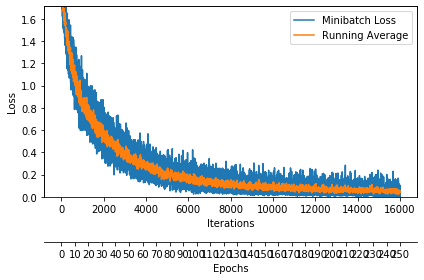

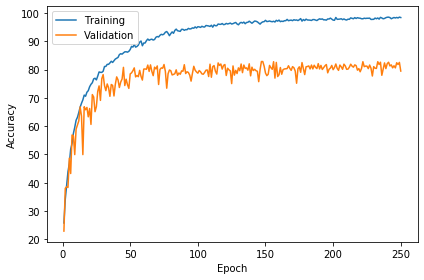

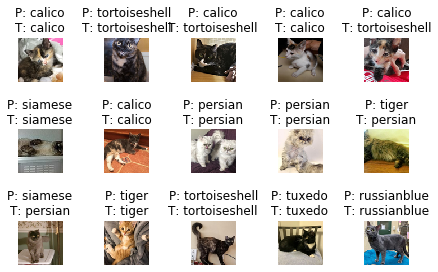

[[181   2   2   8   1   1   4   8]
 [  1 149   8   4   4   7   8  18]
 [  3   8 157   5  10   8   1   4]
 [ 10   3   3 186   4   3   2   3]
 [  1  16  12   7 158   4   3   2]
 [  0  10   3   4   0 182   8   1]
 [  7  15   5   1   6   2 144   1]
 [  6  12   4   2   0   1   6 161]]


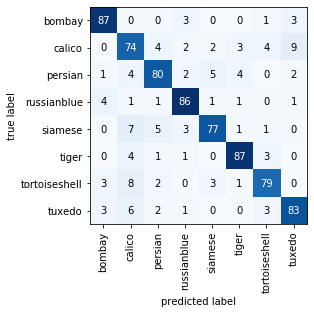

In [81]:
###################################
#**        Data Information     **#
###################################
print(f'batch size: {batch_size}')
print(f'learning rate: {learning_rate}')
print(f'train_val_split: {train_val_split}')
print(f'epochs: {epochs}')


#############################
#**         END           **#
#############################


# Getting count of each cat breed, should be close to 8*0.8*1000 initially..
train_data_distribution = get_cat_count(trainloader, 'training data')
# Getting count of each cat breed, should be close to 8*0.2*1000 initially..
test_data_distribution = get_cat_count(testloader, 'test data')

print(f'training data distribution - {train_data_distribution}')
print(f'test data distribution - {test_data_distribution}')

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=epochs,
                   iter_per_epoch=len(trainloader),
                   results_dir=None,
                   averaging_iterations=10)
plt.show()


plot_accuracy(train_acc_list=train_accuracy_list,
              test_acc_list=test_accuracy_list,
              results_dir=None)
plt.show()

net.cpu()
show_examples(model=net, data_loader=testloader, class_dict=cat_dict)

conf_matrix = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
print(conf_matrix)
plot_confusion_matrix(conf_matrix, class_names=cat_dict.values(), test_data_distribution=test_data_distribution)
plt.show()